In [740]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import torch
import matplotlib
import itertools

In [2]:
FIG_SIZE = 4

matplotlib.rcParams['figure.figsize'] = (FIG_SIZE, FIG_SIZE)

# Tools

In [13]:
def scatter(X, title=None, ax=None, show_axes=False):
    if ax is None:
        ax = plt.gca()
    im = ax.imshow(X, cmap="gray")
    if title is not None:
        ax.set_title(title)
    if not show_axes:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.colorbar(im, ax=ax)

def plot(X, y, title=None, ax=None, show_axes=False, label=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(X, y, label=label)
    if title is not None:
        ax.set_title(title)
    if not show_axes:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

# MNIST dataset

$X \in [-1, 1]^{d,N}$

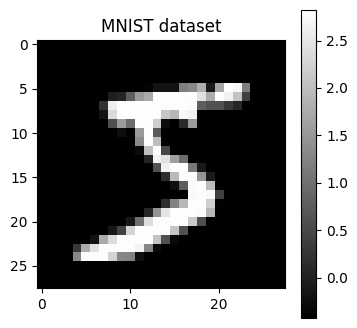

In [35]:
SELECTED_IMG = 0

mnist = datasets.MNIST(root="../datasets",
                download=True,
                train=True,
                transform=transforms.ToTensor())

X = mnist.data.float()
X = (X - X.mean()) / X.std()
X = X[SELECTED_IMG]

scatter(X, title="MNIST dataset", show_axes=True)

# Understand the model formulation

In [59]:
def plot_transformations(interpolation_list, suptitle=None, include_custom_alpha_bar_list=False, n_steps=10):
    m = len(interpolation_list)
    fig, axes = plt.subplots(m, n_steps, figsize=(n_steps * FIG_SIZE, m * FIG_SIZE), constrained_layout=True)

    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=20)

    eps = torch.normal(0, 1, size=X.shape)
    for i, interpolation_fct in enumerate(interpolation_list):
        if include_custom_alpha_bar_list:
            assert isinstance(interpolation_fct, tuple), "interpolation_fct must be a tuple if include_custom_alpha_bar_list is True"
            alpha_bar_list, interpolation_fct = interpolation_fct
            selected_indices = np.linspace(0, len(alpha_bar_list) - 1, n_steps).round().astype(int)
            alpha_bar_list = [alpha_bar_list[idx] for idx in selected_indices]
        else:
            alpha_bar_list = torch.linspace(1, 0, 10)
        for j, alpha_bar in enumerate(alpha_bar_list):
            title, x_coef, eps_coef = interpolation_fct(alpha_bar)
            if j == 0:
                axes[i, j].set_ylabel(title, fontsize=14)
            if i == 0 or include_custom_alpha_bar_list:
                axes[i, j].set_title(f"$\overline{{\\alpha_t}}={alpha_bar:.1f}$", fontsize=18)
            scatter(x_coef*X + eps_coef*eps, ax=axes[i, j], show_axes=True)

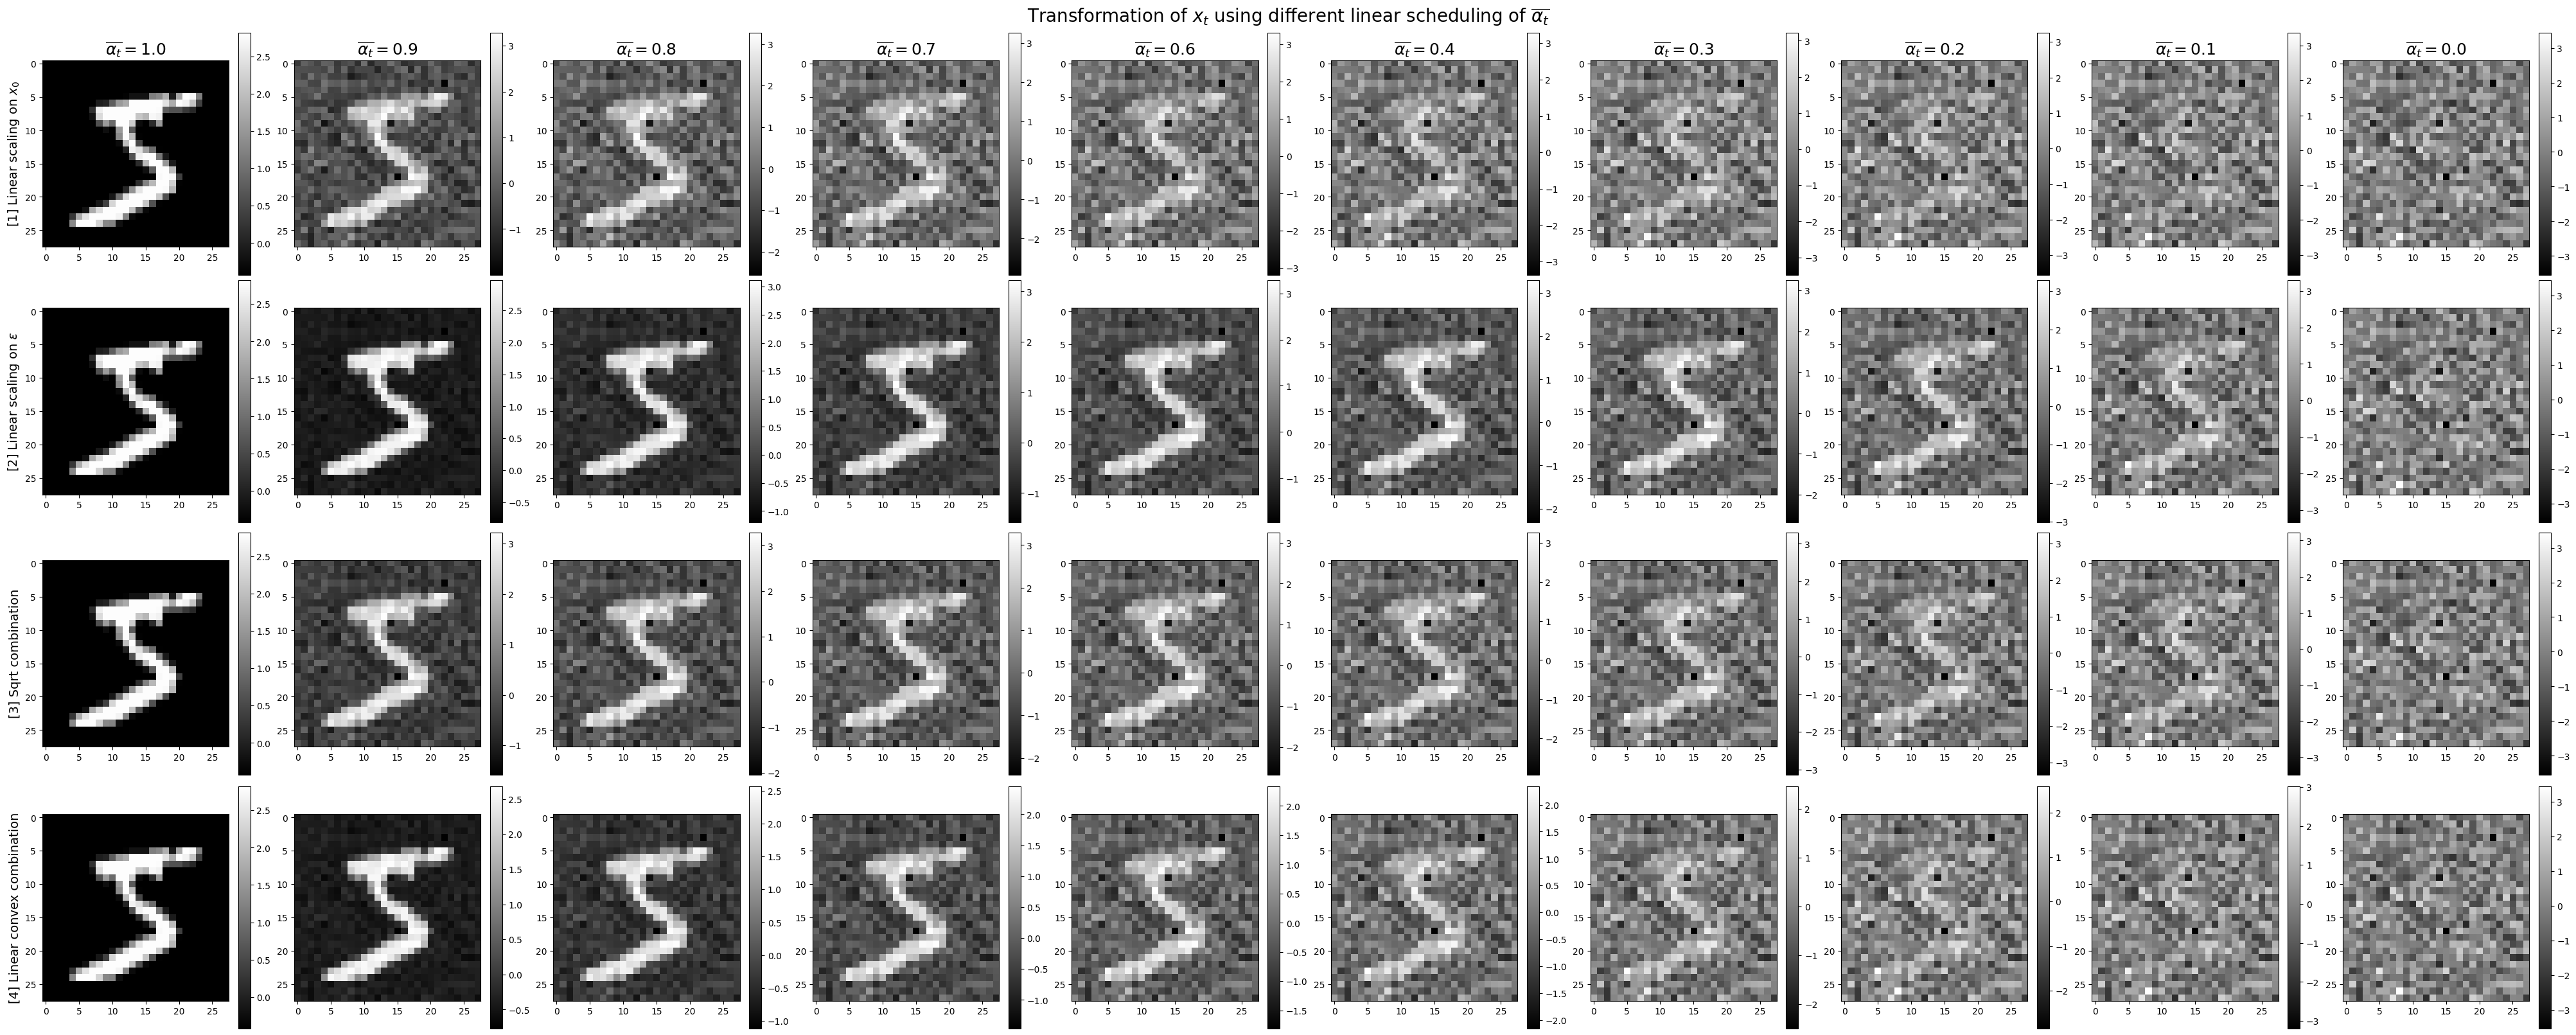

In [60]:
model_1 = lambda alpha: (alpha, (1 - alpha**2)**0.5)
model_2 = lambda alpha: ((1 - (1 - alpha)**2)**0.5, 1 - alpha)
model_3 = lambda alpha: (alpha**0.5, (1 - alpha)**0.5)
model_4 = lambda alpha: (alpha, 1 - alpha)

interpolation_list = [
    lambda alpha: ("[1] Linear scaling on $x_0$", *model_1(alpha)),
    lambda alpha: ("[2] Linear scaling on $\epsilon$", *model_2(alpha)),
    lambda alpha: ("[3] Sqrt combination", *model_3(alpha)),
    lambda alpha: ("[4] Linear convex combination", *model_4(alpha)),
]

plot_transformations(interpolation_list, suptitle="Transformation of $x_t$ using different linear scheduling of $\overline{\\alpha_t}$")

Remind that we are using a linear increasing sequence of $\overline{\alpha_t}$ and **NOT** of the $\alpha_t$.

This experiment allow us to understand the impact of the $\overline{\alpha_t}$ on the model. Using this framework we should be able to easly compare different sceduling strategies and compare their impact on the transformation of the $x_t$.

# Testing different scheduling of $\alpha$

In [39]:
T = 1000

## Fixed $\alpha$ scheduling

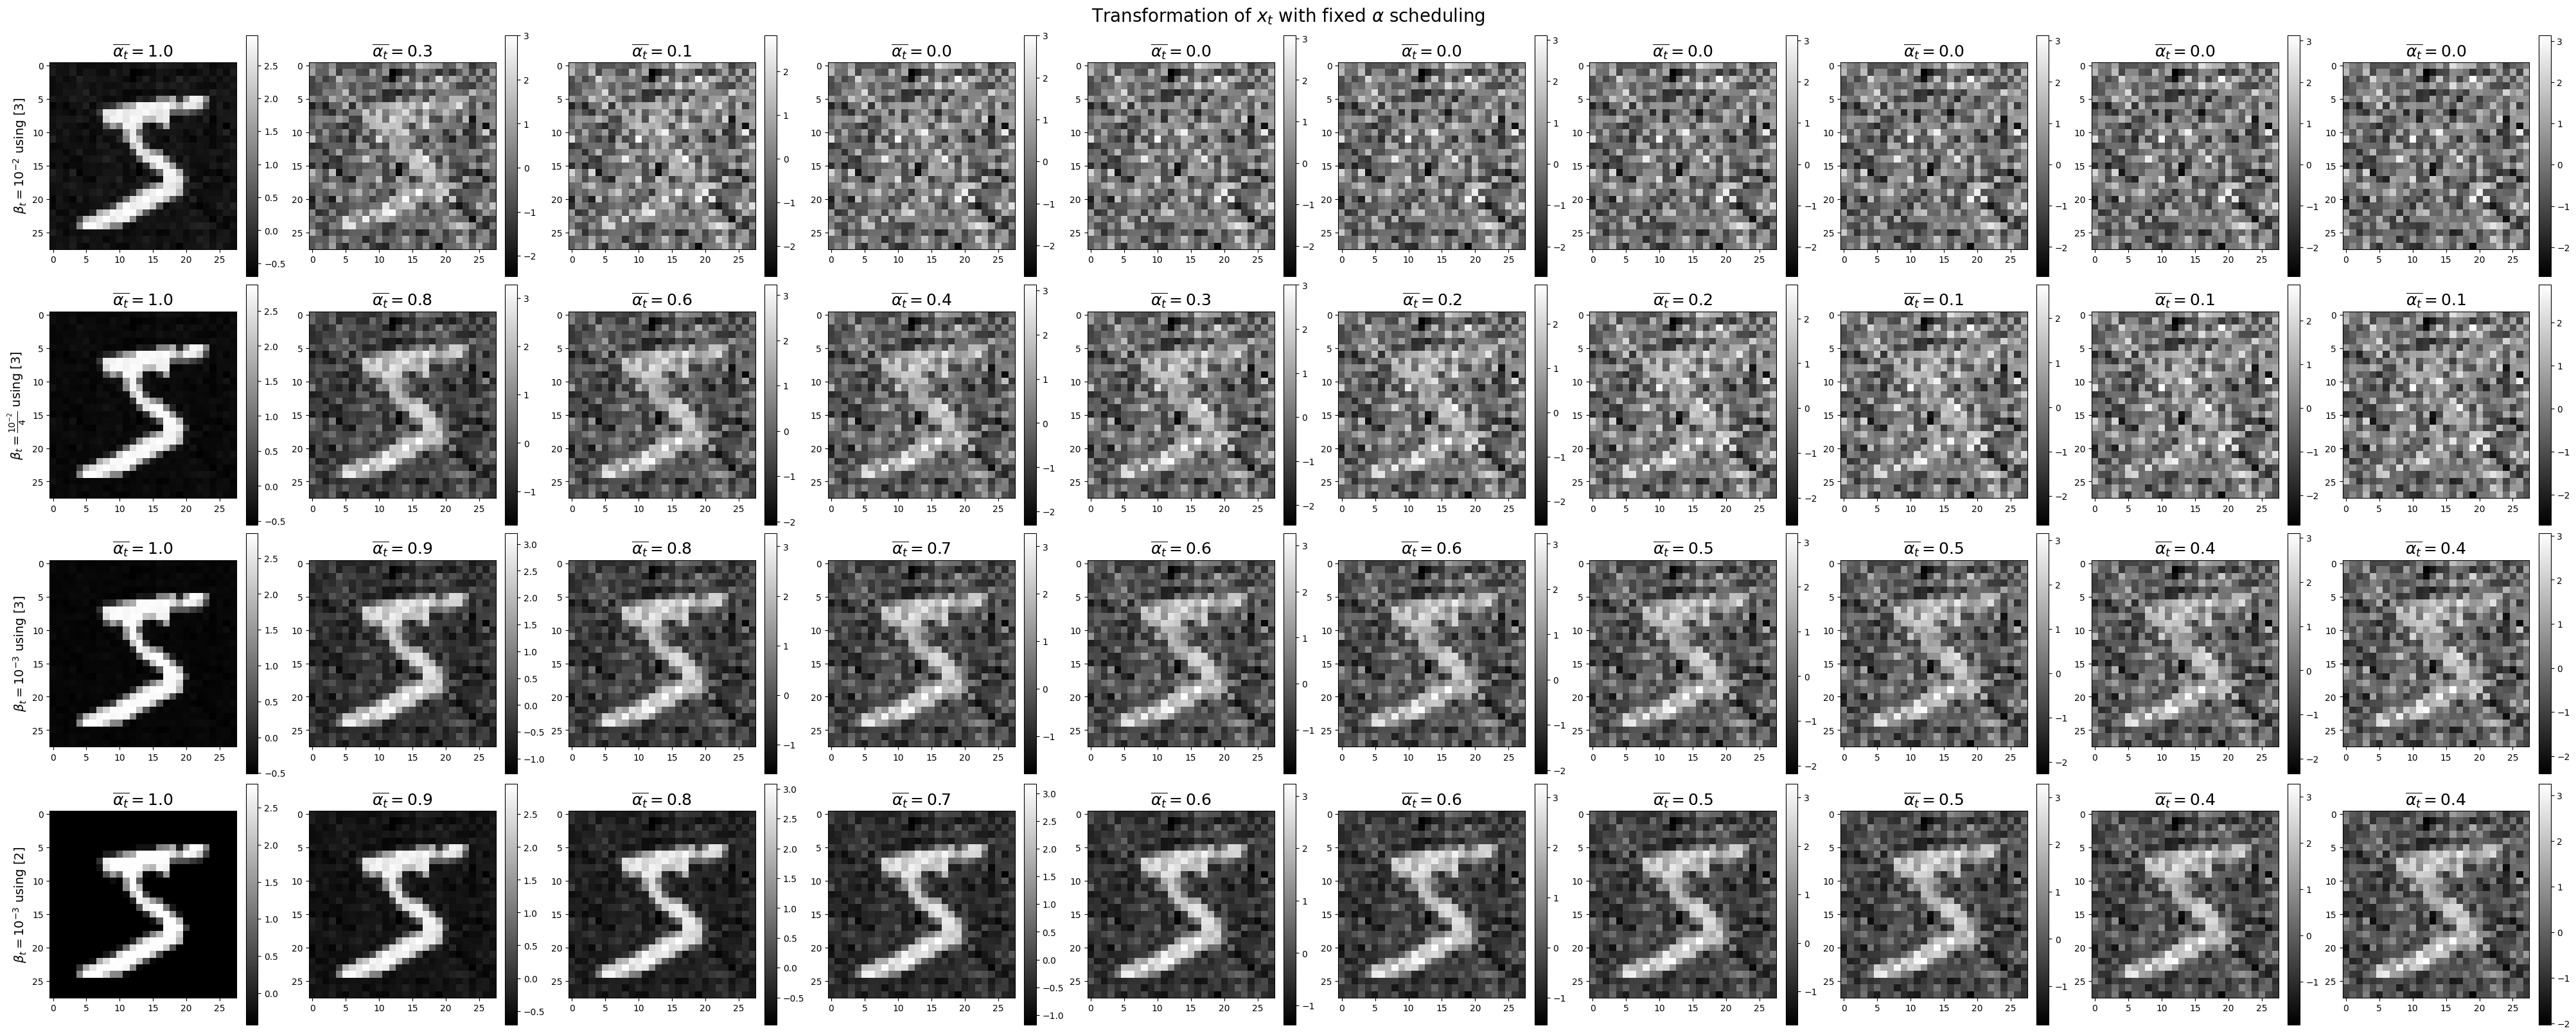

In [61]:
def get_fixed_alpha_bars(cst):
    return (np.ones(T) * cst).cumprod(0)


interpolation_list = [
    (get_fixed_alpha_bars(1 - 1e-2), lambda alpha_bar: ("$\\beta_t=10^{-2}$ using [3]", *model_3(alpha_bar))),
    (get_fixed_alpha_bars(1 - 1e-2/4), lambda alpha_bar: ("$\\beta_t=\\frac{10^{-2}}{4}$ using [3]", *model_3(alpha_bar))),
    (get_fixed_alpha_bars(1 - 1e-3), lambda alpha_bar: ("$\\beta_t=10^{-3}$ using [3]", *model_3(alpha_bar))),
    (get_fixed_alpha_bars(1 - 1e-3), lambda alpha_bar: ("$\\beta_t=10^{-3}$ using [2]", *model_2(alpha_bar))),
]

plot_transformations(interpolation_list, include_custom_alpha_bar_list=True, suptitle="Transformation of $x_t$ with fixed $\\alpha$ scheduling")

## Linear $\alpha$ scheduling

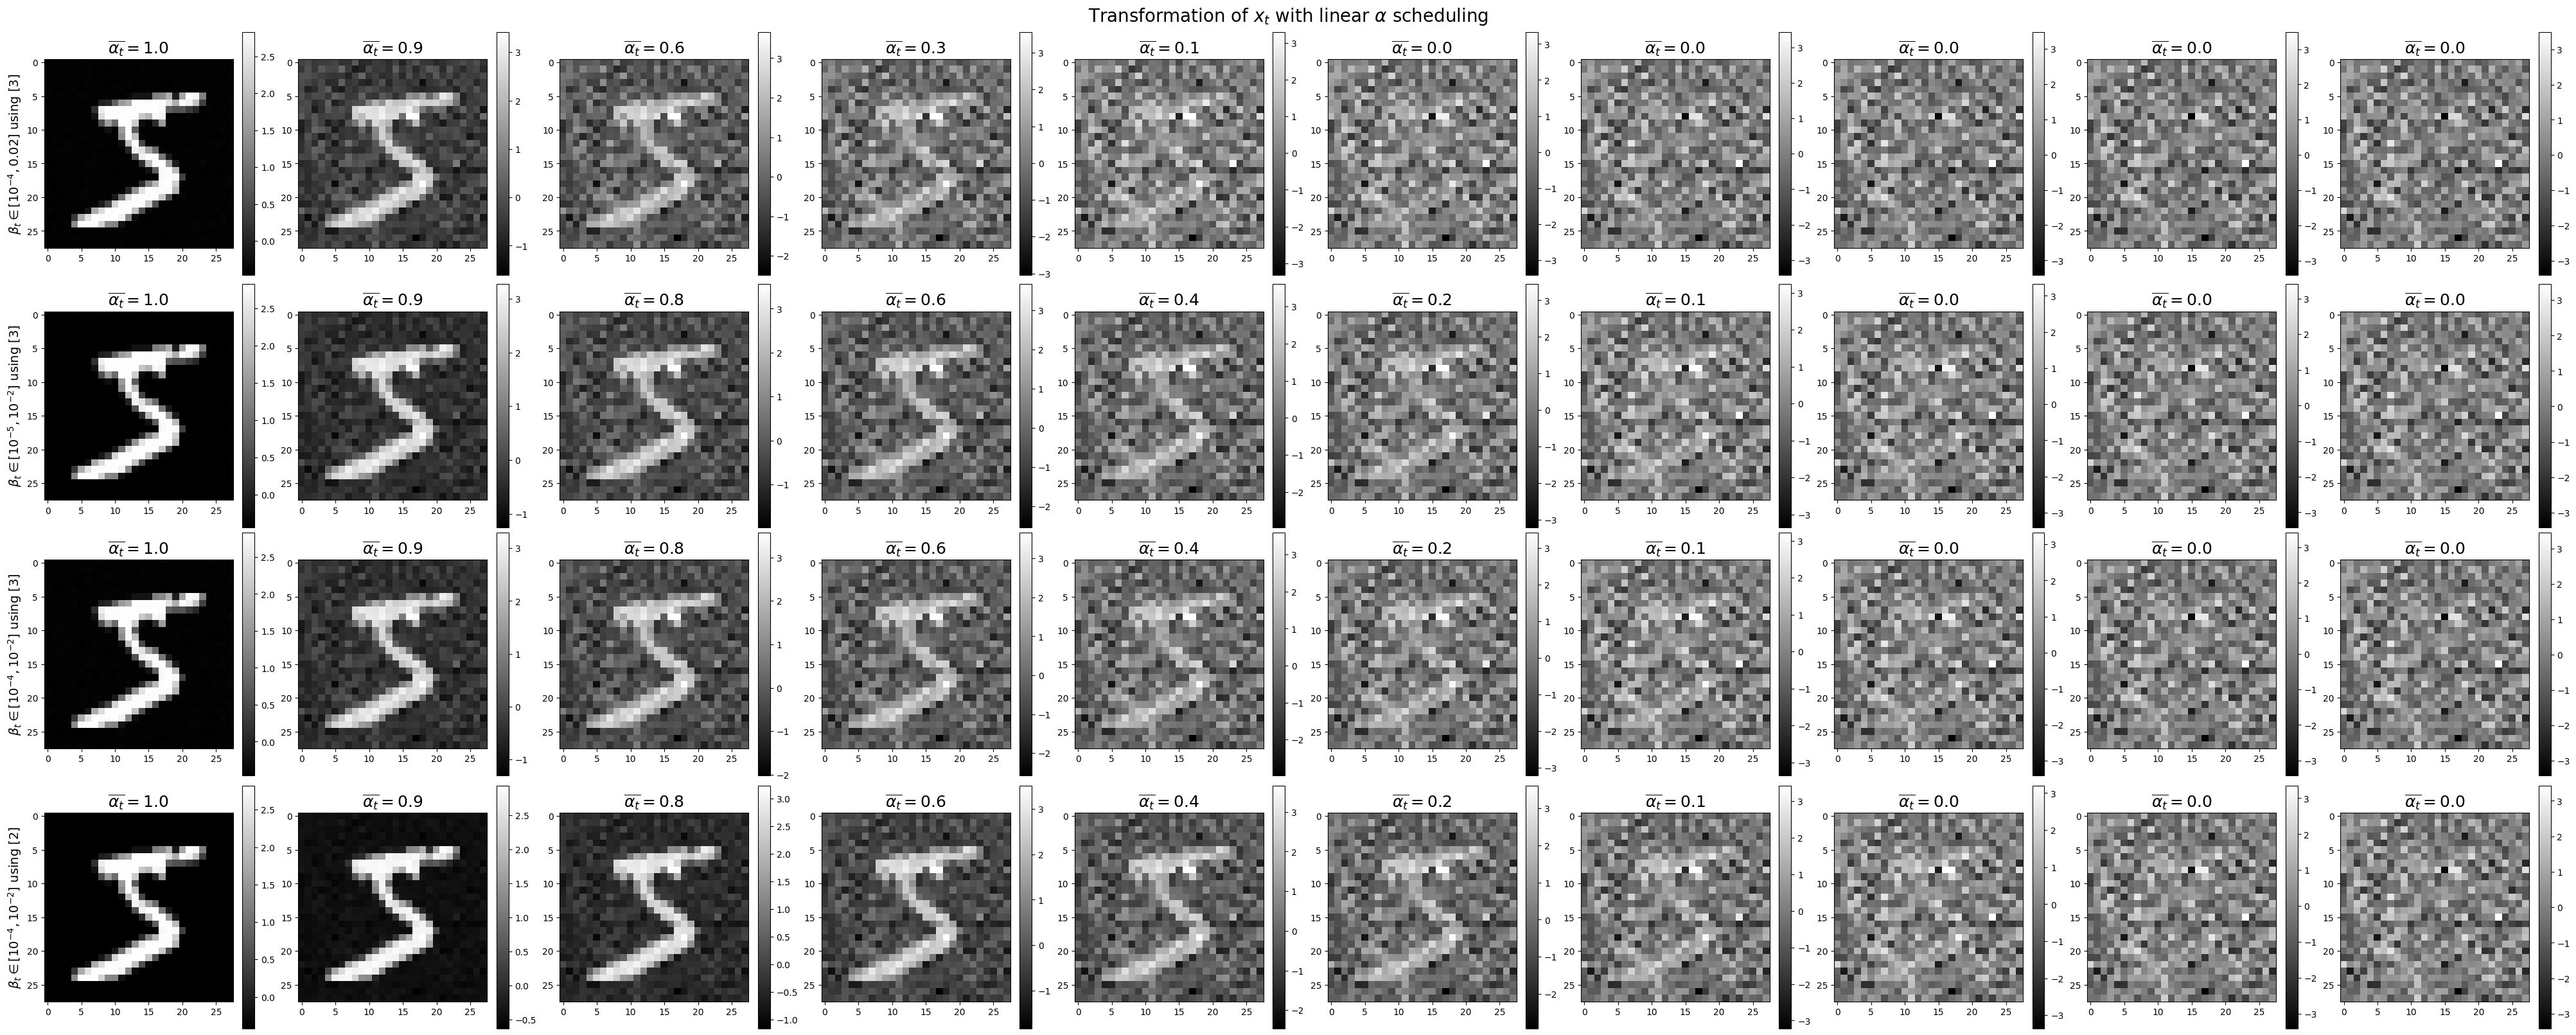

In [62]:
def get_linear_alpha_bars(start, end):
    return (np.linspace(start, end, T)).cumprod(0)


interpolation_list = [
    (get_linear_alpha_bars(1 - 1e-4, 1 - 0.02), lambda alpha_bar: ("$\\beta_t \in [10^{-4}, 0.02]$ using [3]", *model_3(alpha_bar))), # from "Denoising Diffusion Probabilistic Models"
    (get_linear_alpha_bars(1 - 1e-5, 1 - 1e-2), lambda alpha_bar: ("$\\beta_t \in [10^{-5}, 10^{-2}]$ using [3]", *model_3(alpha_bar))),
    (get_linear_alpha_bars(1 - 1e-4, 1 - 1e-2), lambda alpha_bar: ("$\\beta_t \in [10^{-4}, 10^{-2}]$ using [3]", *model_3(alpha_bar))),
    (get_linear_alpha_bars(1 - 1e-5, 1 - 1e-2), lambda alpha_bar: ("$\\beta_t \in [10^{-4}, 10^{-2}]$ using [2]", *model_2(alpha_bar))),
]

plot_transformations(interpolation_list, include_custom_alpha_bar_list=True, suptitle="Transformation of $x_t$ with linear $\\alpha$ scheduling")

## Linear $\overline{\alpha}$ scheduling (linspace scheduling)

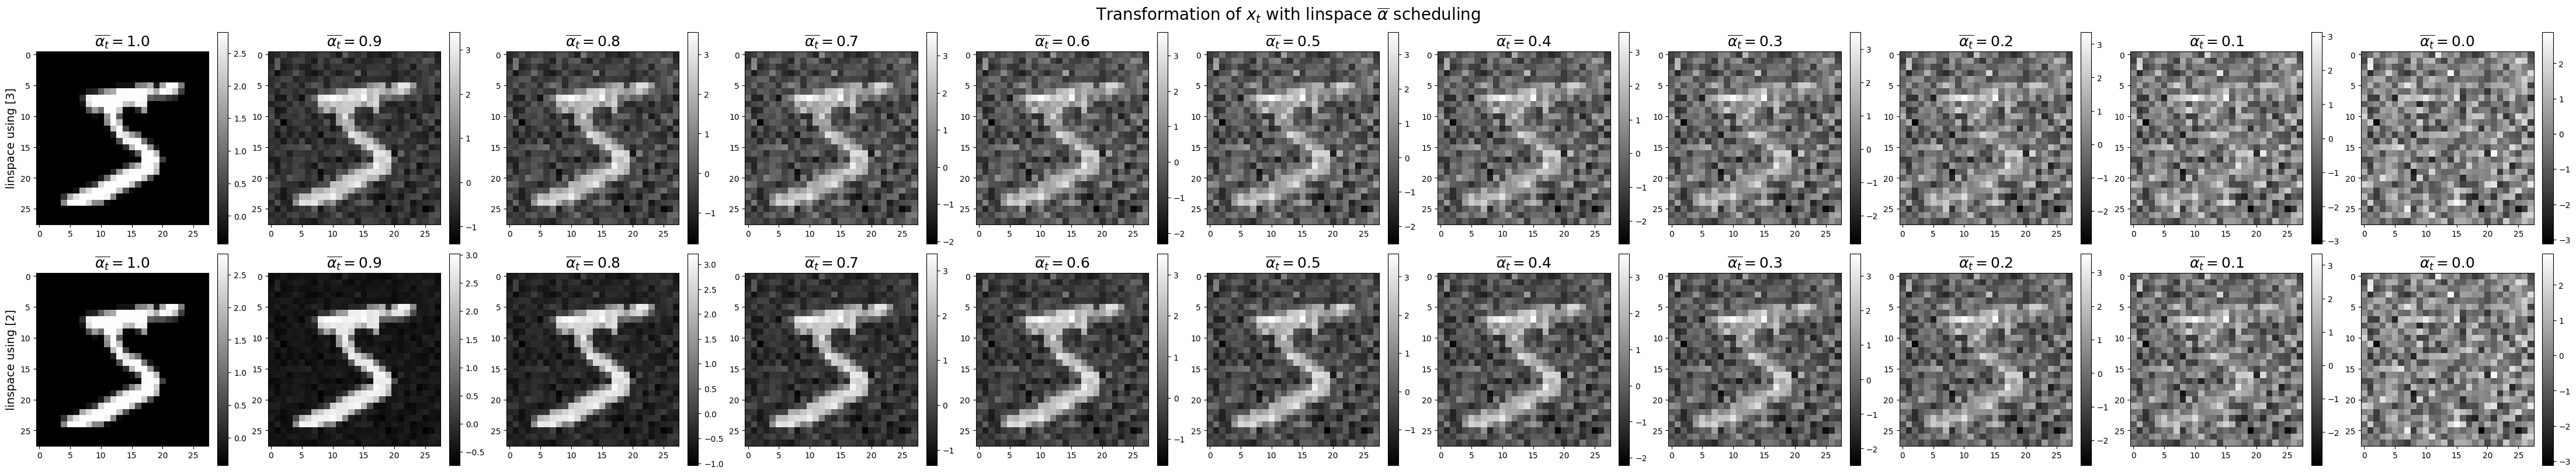

In [65]:
interpolation_list = [
    (np.linspace(1, 0, T), lambda alpha_bar: ("linspace using [3]", *model_3(alpha_bar))),
    (np.linspace(1, 0, T), lambda alpha_bar: ("linspace using [2]", *model_2(alpha_bar))),
]

plot_transformations(interpolation_list, include_custom_alpha_bar_list=True, suptitle="Transformation of $x_t$ with linspace $\overline{\\alpha}$ scheduling", n_steps=11)

## Cosine $\alpha$ scheduling

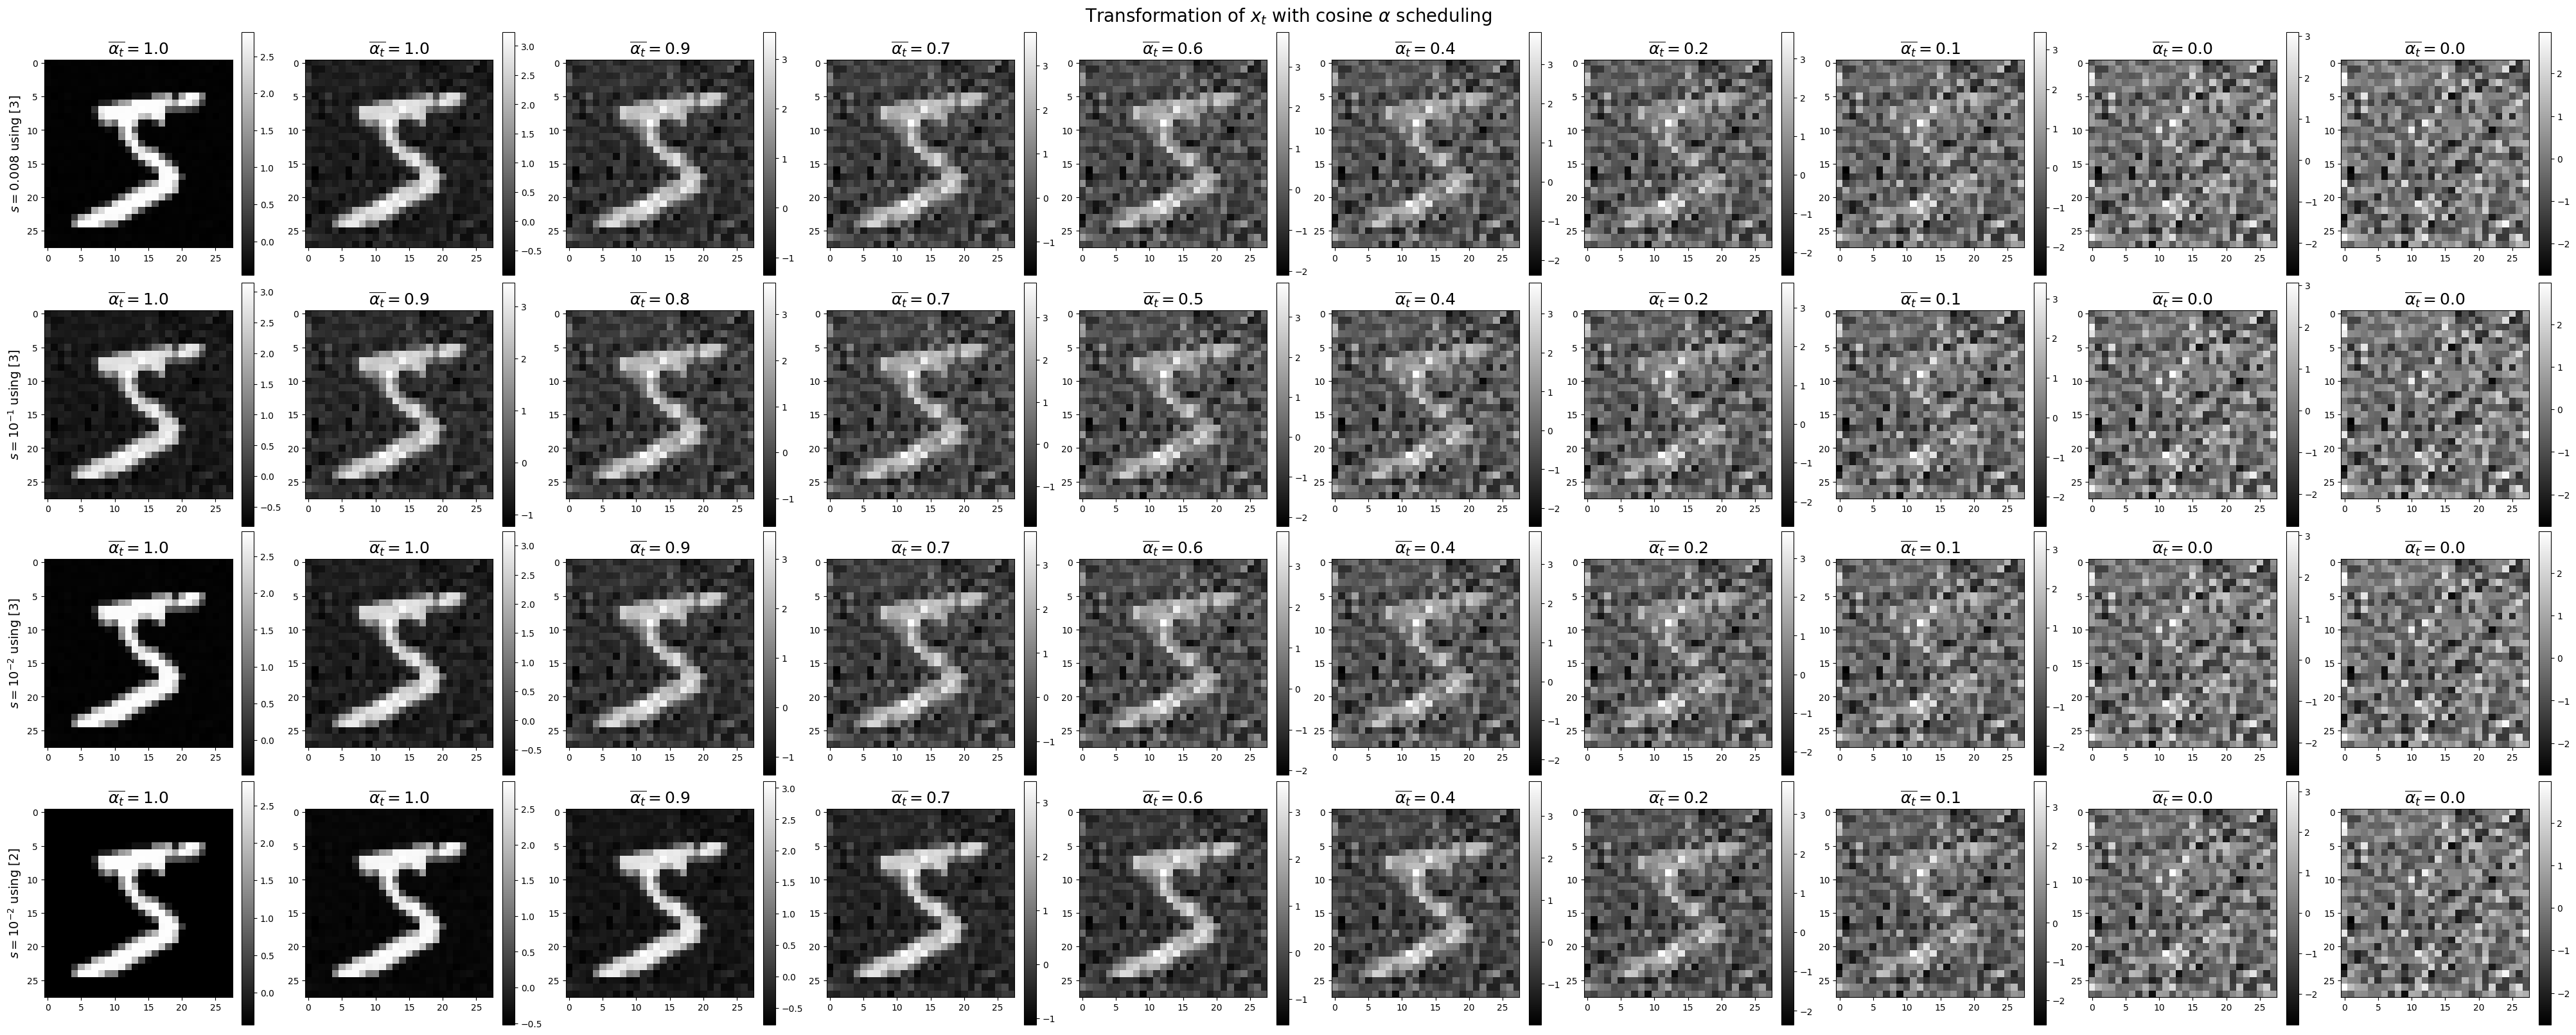

In [64]:
def get_cosine_alpha_bars(s, n_steps=T):
    def f(t):
        return np.cos((t/n_steps + s)/(1 + s) * np.pi/2)**2
    return f(np.linspace(0, n_steps, n_steps))


interpolation_list = [
    (get_cosine_alpha_bars(0.008), lambda alpha_bar: ("$s = 0.008$ using [3]", *model_3(alpha_bar))),
    (get_cosine_alpha_bars(1e-1), lambda alpha_bar: ("$s = 10^{-1}$ using [3]", *model_3(alpha_bar))),
    (get_cosine_alpha_bars(1e-2), lambda alpha_bar: ("$s = 10^{-2}$ using [3]", *model_3(alpha_bar))),
    (get_cosine_alpha_bars(1e-2), lambda alpha_bar: ("$s = 10^{-2}$ using [2]", *model_2(alpha_bar))),
]

plot_transformations(interpolation_list, include_custom_alpha_bar_list=True, suptitle="Transformation of $x_t$ with cosine $\\alpha$ scheduling")

# Comparing best $\alpha$ schedules

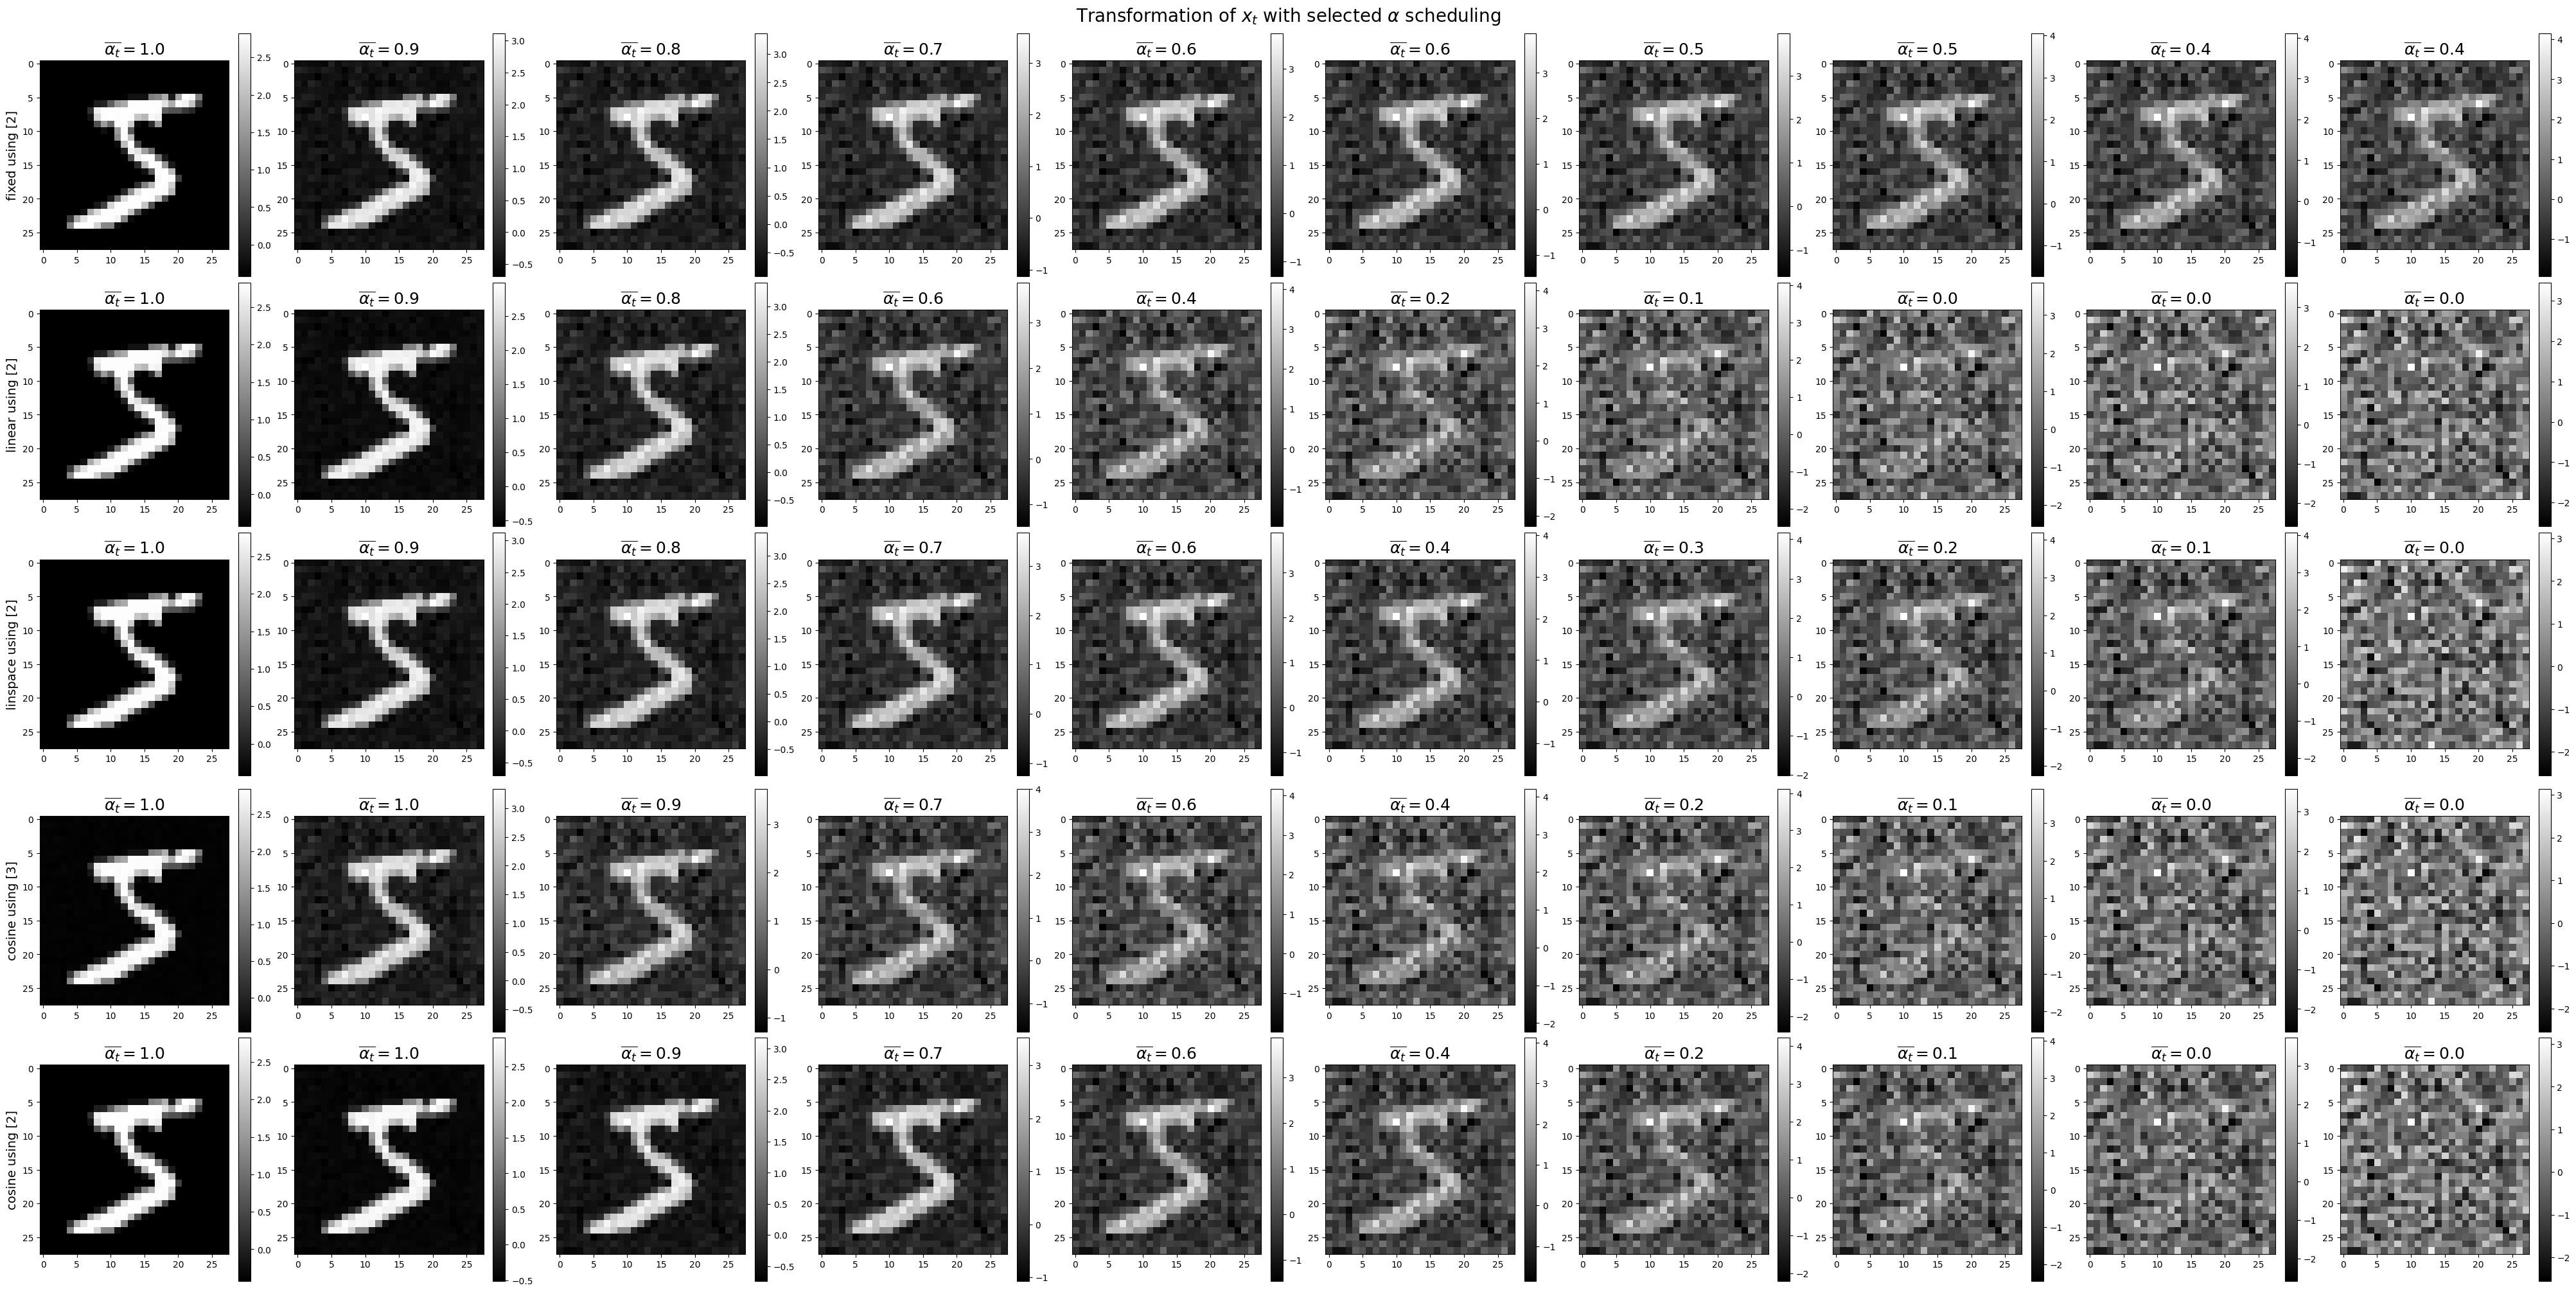

In [66]:
selected_interpolation_list = [
    (get_fixed_alpha_bars(1 - 1e-3), lambda alpha_bar: ("fixed using [2]", *model_2(alpha_bar))),
    (get_linear_alpha_bars(1 - 1e-5, 1 - 1e-2), lambda alpha_bar: ("linear using [2]", *model_2(alpha_bar))),
    (np.linspace(1, 0, T), lambda alpha_bar: ("linspace using [2]", *model_2(alpha_bar))),
    (get_cosine_alpha_bars(1e-2), lambda alpha_bar: ("cosine using [3]", *model_3(alpha_bar))),
    (get_cosine_alpha_bars(1e-2), lambda alpha_bar: ("cosine using [2]", *model_2(alpha_bar))),
]

plot_transformations(selected_interpolation_list, include_custom_alpha_bar_list=True, suptitle="Transformation of $x_t$ with selected $\\alpha$ scheduling")

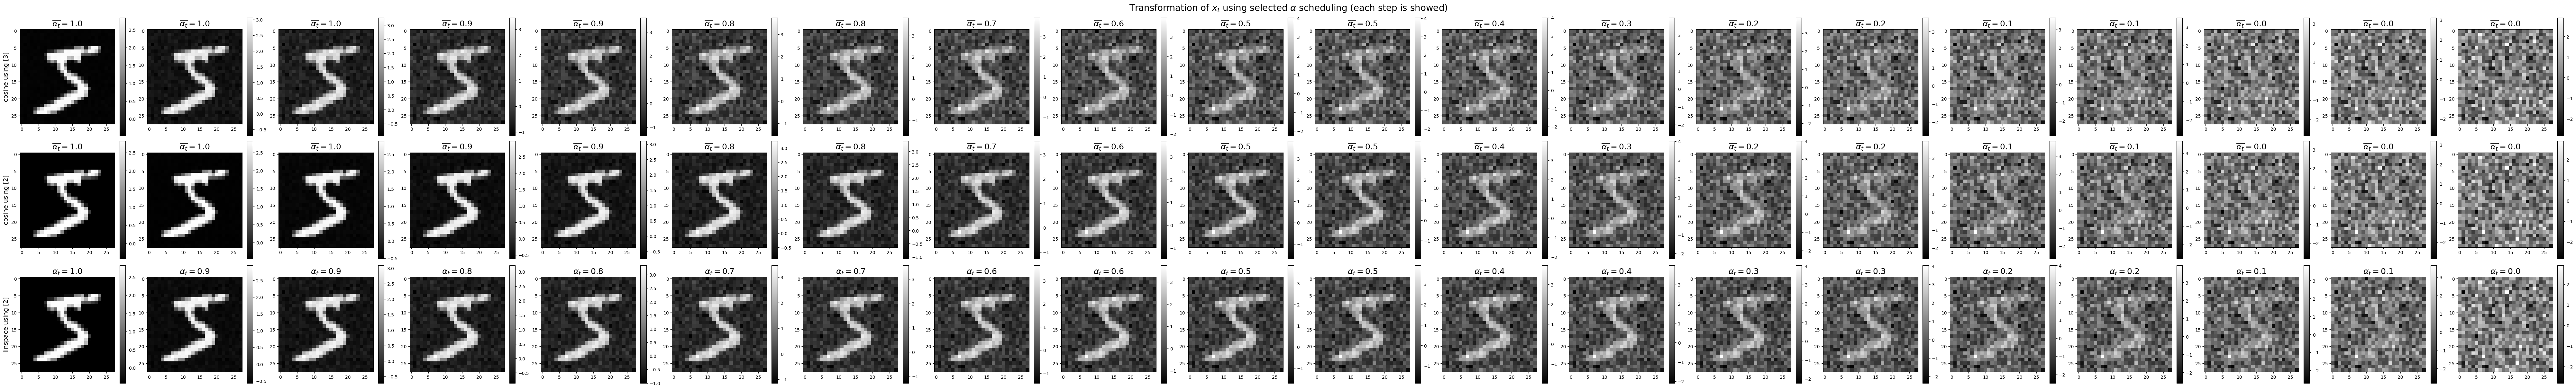

In [67]:
T_small = 20

selected_small_T_interpolation_list = [
    (get_cosine_alpha_bars(1e-2, n_steps=T_small), lambda alpha_bar: ("cosine using [3]", *model_3(alpha_bar))),
    (get_cosine_alpha_bars(1e-2, n_steps=T_small), lambda alpha_bar: ("cosine using [2]", *model_2(alpha_bar))),
    (np.linspace(1, 0, T_small), lambda alpha_bar: ("linspace using [2]", *model_2(alpha_bar))),
]

plot_transformations(selected_small_T_interpolation_list, include_custom_alpha_bar_list=True, suptitle="Transformation of $x_t$ using selected $\\alpha$ scheduling (each step is showed)", n_steps=T_small)